# Анализ гипотез для рекомендательной системы Freedom Ticketon

В этом ноутбуке мы проанализируем и визуализируем данные, чтобы подтвердить или опровергнуть ключевые гипотезы, на которых основана наша рекомендательная система.

## 1. Импорт библиотек и загрузка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import sys
from tqdm.notebook import tqdm  

plt.style.use('ggplot')
sns.set_palette('viridis')

plt.rcParams['font.family'] = 'DejaVu Sans'

plt.rcParams['figure.figsize'] = (12, 8)

%matplotlib inline

def cell_end():
    print("Cell ended!")
    sys.stdout.flush()

print("Загрузка данных...")
train_test = pd.read_csv('train_test.csv')
events_description = pd.read_csv('events_description.csv')
submission = pd.read_csv('submission.csv')
print(f"Данные загружены: {train_test.shape[0]} взаимодействий, {events_description.shape[0]} мероприятий")

cell_end()

Загрузка данных...
Данные загружены: 572032 взаимодействий, 6028 мероприятий
Cell ended!


## 2. Предобработка данных

In [2]:
train_test['reservation_time'] = pd.to_datetime(train_test['reservation_time'])

paid_interactions = train_test[train_test['sale_status'] == 'PAID'].copy()
print(f"Отфильтровано {paid_interactions.shape[0]} оплаченных билетов")

history_interactions = paid_interactions[paid_interactions['part_dataset'] == 'train'].copy()
march_interactions = paid_interactions[paid_interactions['part_dataset'] == 'test'].copy()
print(f"Данные до марта: {history_interactions.shape[0]} записей")
print(f"Данные марта: {march_interactions.shape[0]} записей")

history_with_details = pd.merge(history_interactions, events_description, on='item_id', how='left')
march_with_details = pd.merge(march_interactions, events_description, on='item_id', how='left')

for df in [history_interactions, march_interactions, paid_interactions]:
    df['day_of_week'] = df['reservation_time'].dt.day_name()
    df['hour_of_day'] = df['reservation_time'].dt.hour
    df['month'] = df['reservation_time'].dt.month
    df['is_weekend'] = df['day_of_week'].isin(['Saturday', 'Sunday']).astype(int)

history_grouped = history_with_details.groupby('user_id')
march_grouped = march_with_details.groupby('user_id')
paid_grouped = paid_interactions.groupby('user_id')

print("Данные предобработаны и сгруппированы")
cell_end()

Отфильтровано 464253 оплаченных билетов
Данные до марта: 358551 записей
Данные марта: 105702 записей
Данные предобработаны и сгруппированы
Cell ended!


## 3. Гипотеза 1: Жанровые и типовые предпочтения

Анализируем, действительно ли пользователи предпочитают мероприятия определенных жанров и типов.

Анализ жанровых предпочтений...


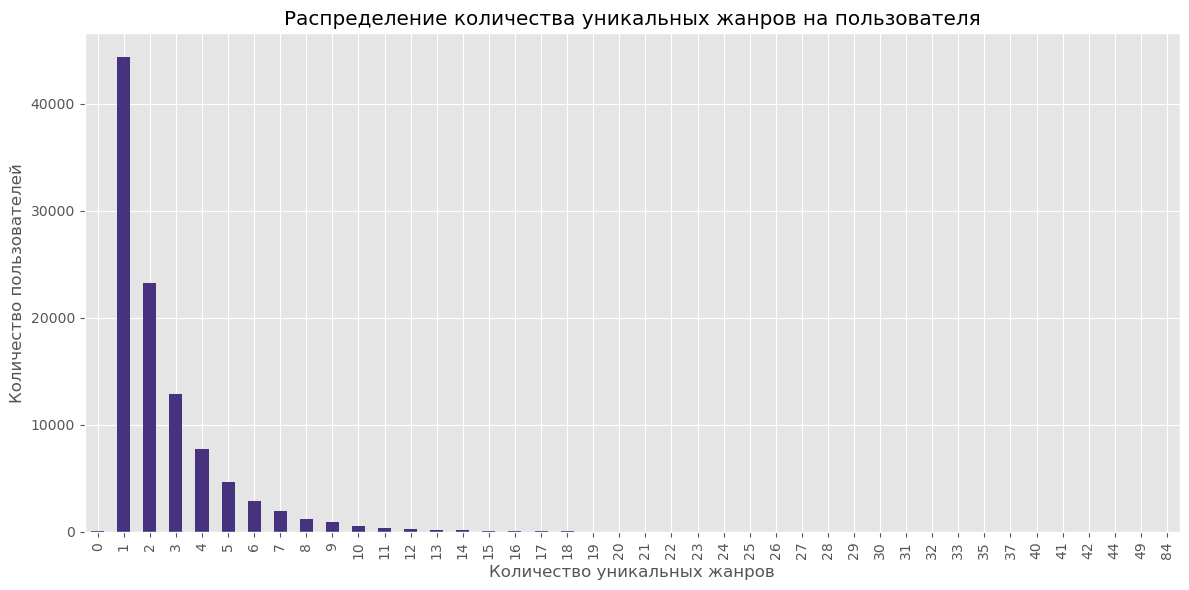


Анализ стабильности жанровых предпочтений:


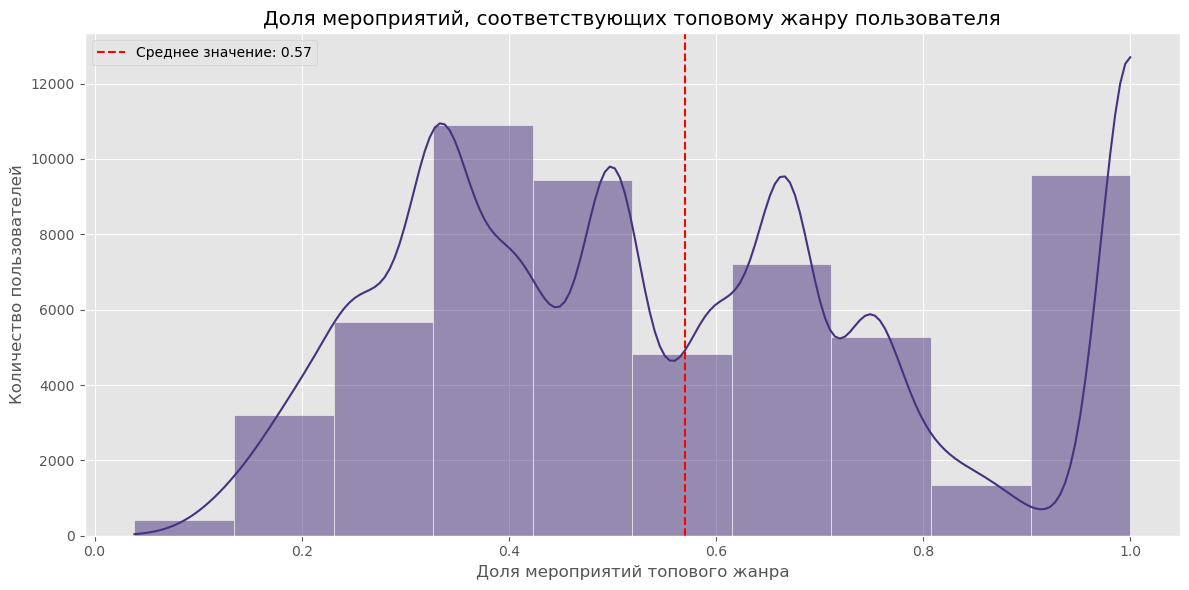

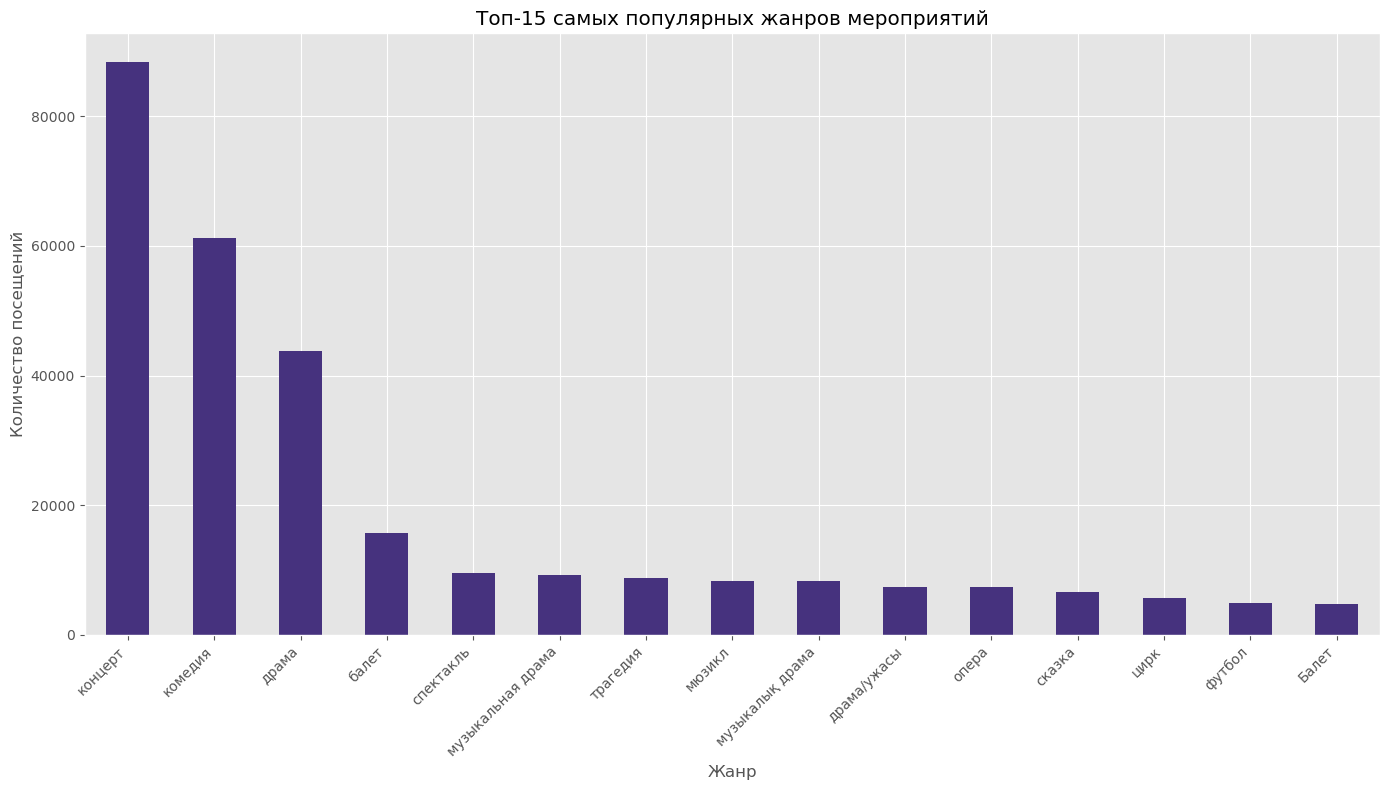

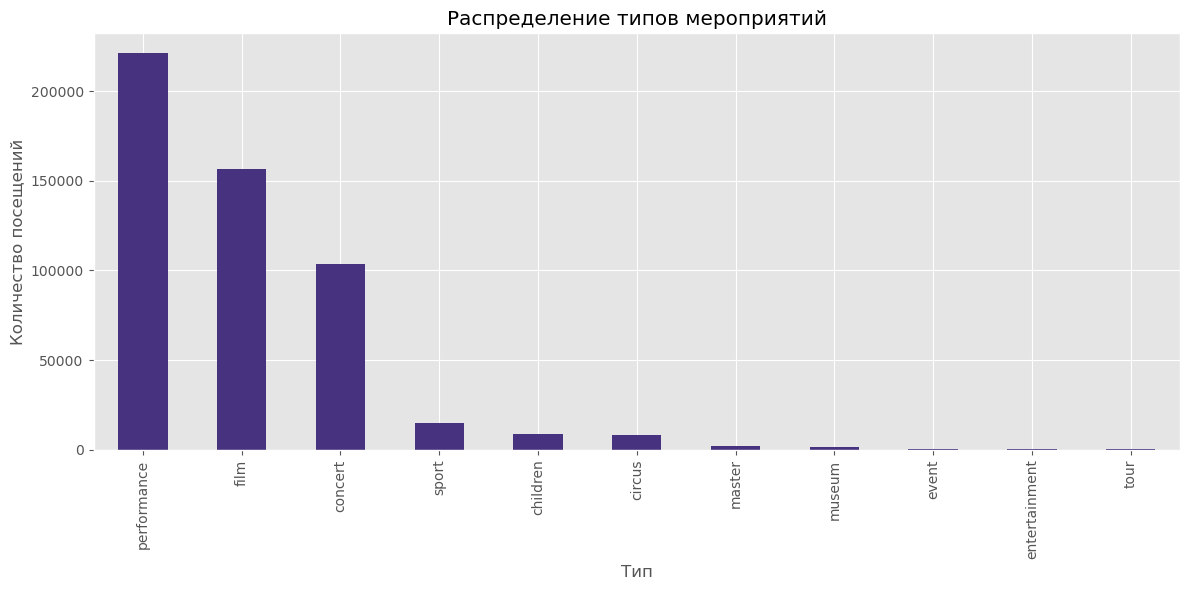

Анализ жанровых и типовых предпочтений завершен
Cell ended!


In [3]:
print("Анализ жанровых предпочтений...")

def count_unique_genres(x):
    return len(x.dropna().unique())

user_genre_counts = history_grouped['film_genre'].agg(count_unique_genres)
genre_counts_series = pd.Series(user_genre_counts)

plt.figure(figsize=(12, 6))
ax = genre_counts_series.value_counts().sort_index().plot(kind='bar')
plt.title('Распределение количества уникальных жанров на пользователя')
plt.xlabel('Количество уникальных жанров')
plt.ylabel('Количество пользователей')
plt.tight_layout()
plt.savefig('unique_genres_per_user.png')
plt.show()

print("\nАнализ стабильности жанровых предпочтений:")

def top_genre_ratio(group):
    if len(group) >= 3:  # Только пользователи с хотя бы 3 мероприятиями
        genres = group['film_genre'].dropna()
        if not genres.empty:
            genre_counts = genres.value_counts()
            if not genre_counts.empty:
                return genre_counts.iloc[0] / len(genres)
    return np.nan

user_top_genre_ratio = history_grouped.apply(top_genre_ratio).dropna()
top_genre_ratio_series = pd.Series(user_top_genre_ratio)

plt.figure(figsize=(12, 6))
sns.histplot(top_genre_ratio_series, bins=10, kde=True)
plt.title('Доля мероприятий, соответствующих топовому жанру пользователя')
plt.xlabel('Доля мероприятий топового жанра')
plt.ylabel('Количество пользователей')
plt.axvline(top_genre_ratio_series.mean(), color='red', linestyle='--', 
            label=f'Среднее значение: {top_genre_ratio_series.mean():.2f}')
plt.legend()
plt.tight_layout()
plt.savefig('top_genre_ratio.png')
plt.show()

plt.figure(figsize=(14, 8))
top_genres = history_with_details['film_genre'].value_counts().head(15)
ax = top_genres.plot(kind='bar')
plt.title('Топ-15 самых популярных жанров мероприятий')
plt.xlabel('Жанр')
plt.ylabel('Количество посещений')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('top_genres.png')
plt.show()

plt.figure(figsize=(12, 6))
type_counts = history_with_details['film_type'].value_counts()
ax = type_counts.plot(kind='bar')
plt.title('Распределение типов мероприятий')
plt.xlabel('Тип')
plt.ylabel('Количество посещений')
plt.tight_layout()
plt.savefig('event_types.png')
plt.show()

print("Анализ жанровых и типовых предпочтений завершен")
cell_end()

## 4. Гипотеза 2: Предпочтения по дням недели

Анализируем, есть ли у пользователей устойчивые предпочтения по дням недели.

Анализ предпочтений по дням недели...


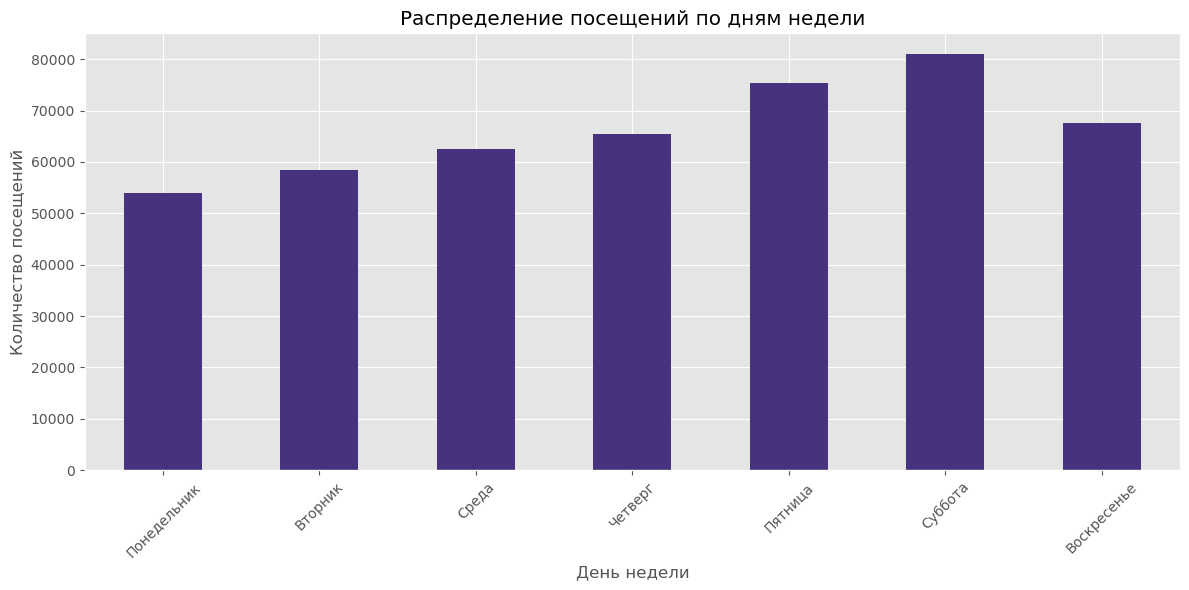

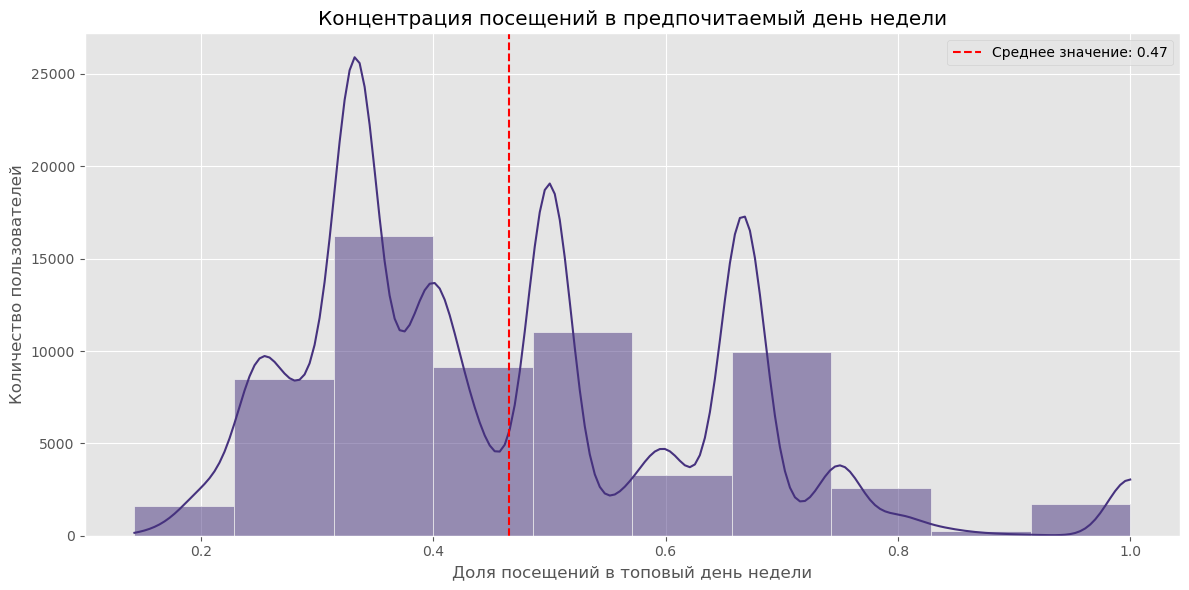

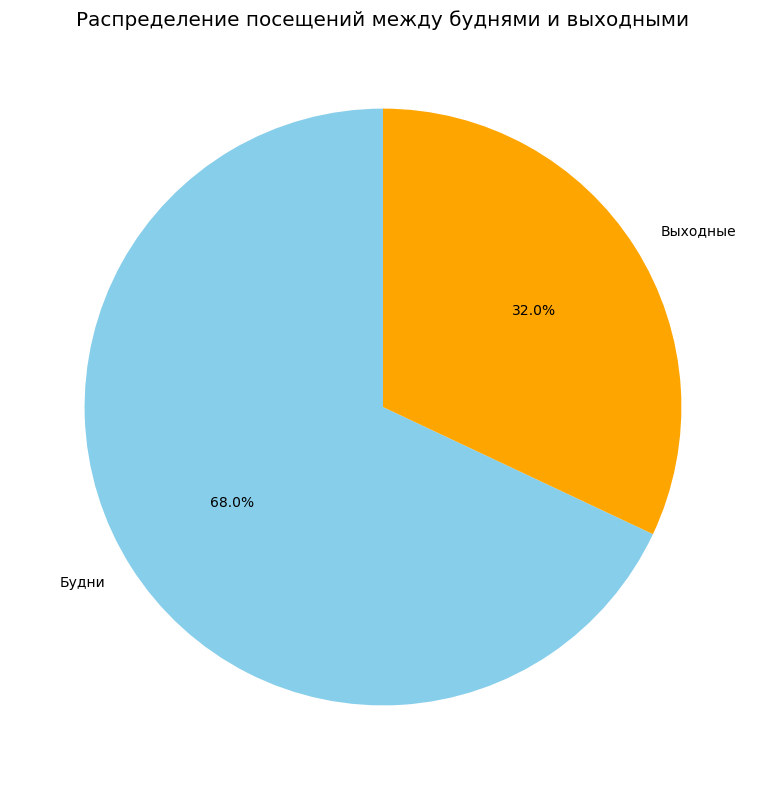

Анализ предпочтений по дням недели завершен
Cell ended!


In [4]:
print("Анализ предпочтений по дням недели...")

plt.figure(figsize=(12, 6))

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_counts = paid_interactions['day_of_week'].value_counts().reindex(day_order)

day_labels = ['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье']

ax = day_counts.plot(kind='bar')
plt.title('Распределение посещений по дням недели')
plt.xlabel('День недели')
plt.xticks(range(len(day_labels)), day_labels, rotation=45)
plt.ylabel('Количество посещений')
plt.tight_layout()
plt.savefig('weekday_distribution.png')
plt.show()

def top_day_ratio(group):
    if len(group) >= 3:  # Только пользователи с хотя бы 3 посещениями
        days = group['day_of_week']
        if not days.empty:
            day_counts = days.value_counts()
            if not day_counts.empty:
                return day_counts.iloc[0] / len(days)
    return np.nan

user_day_consistency = paid_grouped.apply(top_day_ratio).dropna()
day_consistency_series = pd.Series(user_day_consistency)

plt.figure(figsize=(12, 6))
sns.histplot(day_consistency_series, bins=10, kde=True)
plt.title('Концентрация посещений в предпочитаемый день недели')
plt.xlabel('Доля посещений в топовый день недели')
plt.ylabel('Количество пользователей')
plt.axvline(day_consistency_series.mean(), color='red', linestyle='--', 
           label=f'Среднее значение: {day_consistency_series.mean():.2f}')
plt.legend()
plt.tight_layout()
plt.savefig('day_consistency.png')
plt.show()

weekday_weekend_ratio = paid_interactions['is_weekend'].value_counts(normalize=True)
plt.figure(figsize=(8, 8))
plt.pie(weekday_weekend_ratio, labels=['Будни', 'Выходные'], autopct='%1.1f%%', 
        colors=['skyblue', 'orange'], startangle=90)
plt.title('Распределение посещений между буднями и выходными')
plt.tight_layout()
plt.savefig('weekday_weekend_ratio.png')
plt.show()

print("Анализ предпочтений по дням недели завершен")
cell_end()

## 5. Гипотеза 3: Частота посещений влияет на рекомендации

Анализируем разницу между частыми и редкими посетителями мероприятий.

Анализ частоты посещений...


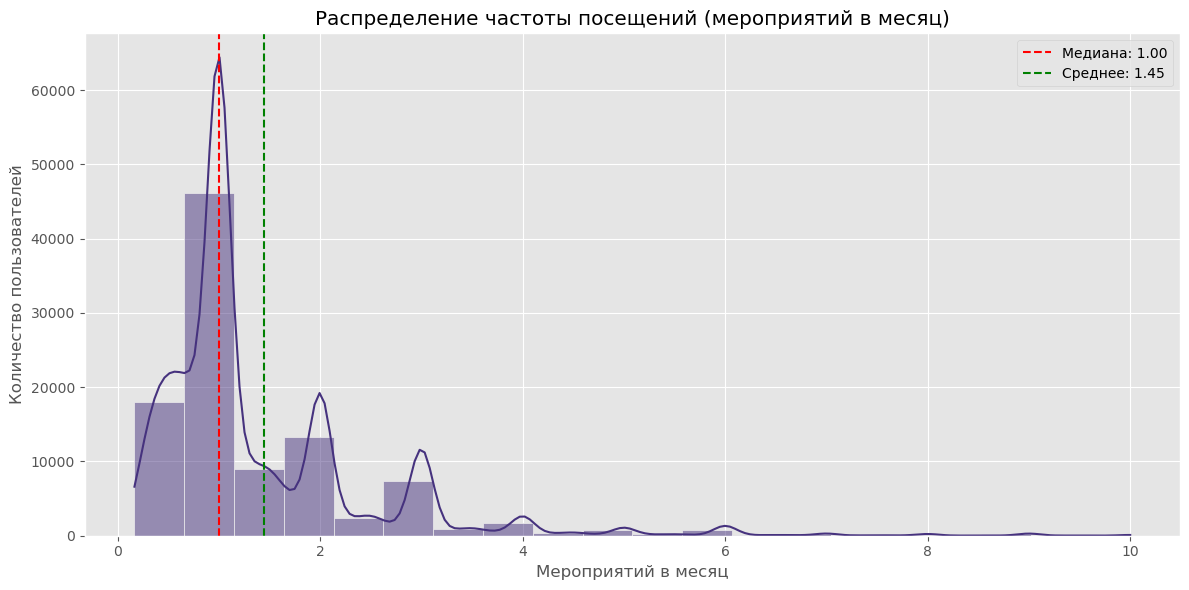


Статистика по группам частоты:
Высокочастотные пользователи (>3 мер./мес.): 5767
Среднечастотные пользователи (1-3 мер./мес.): 33449
Низкочастотные пользователи (<1 мер./мес.): 62882


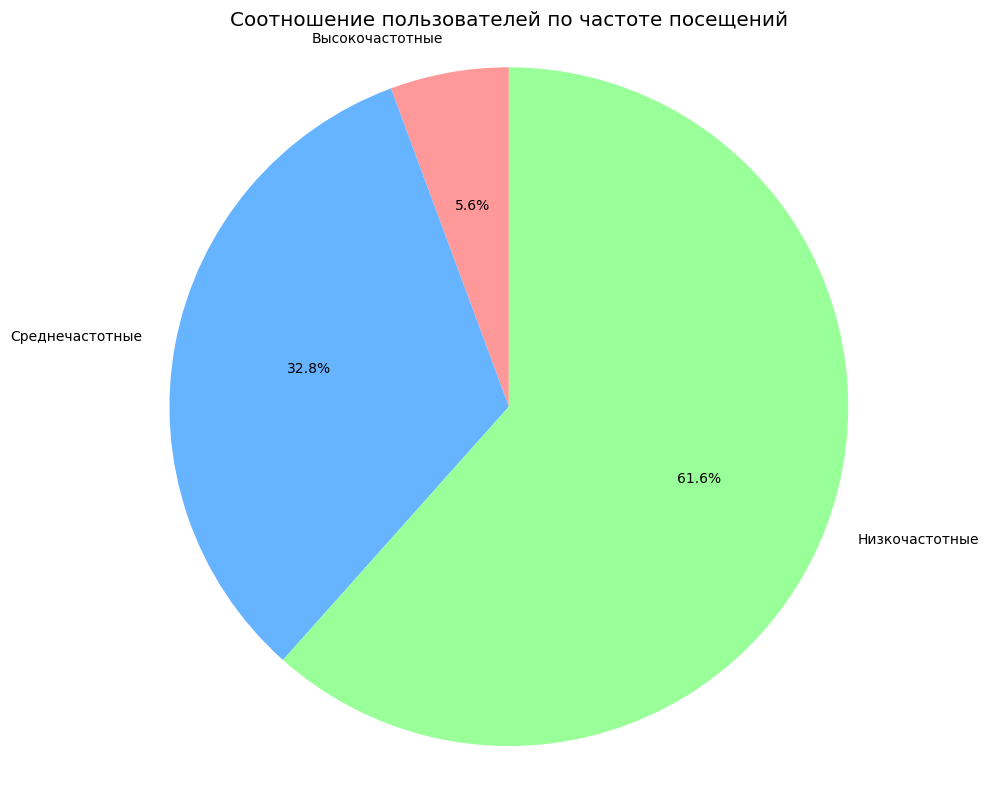

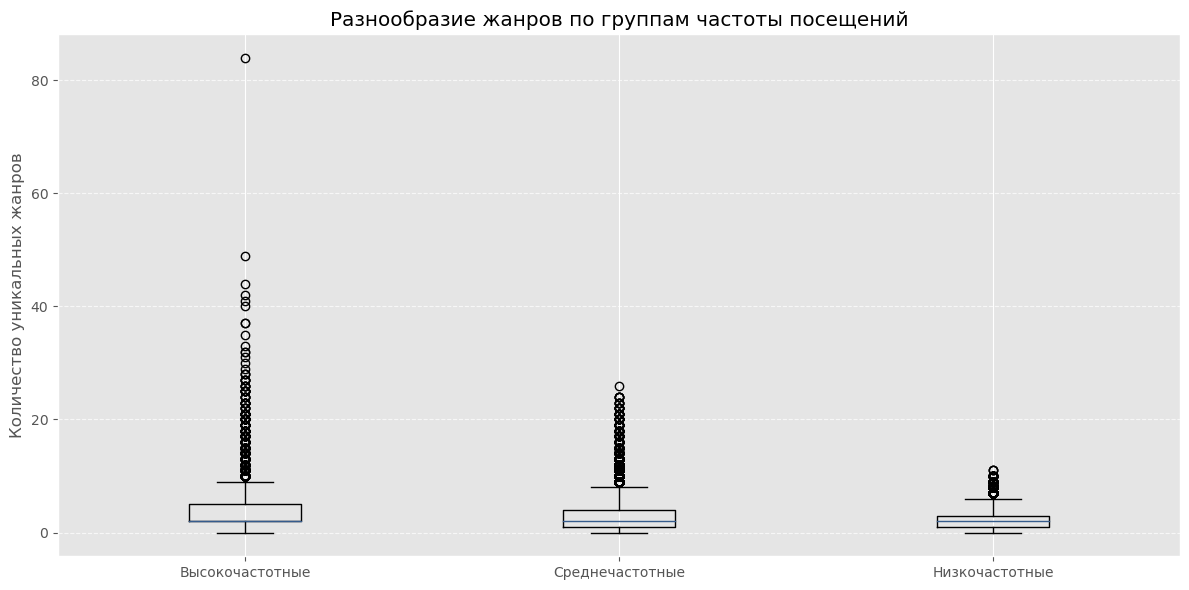

Анализ частоты посещений завершен
Cell ended!


In [5]:
print("Анализ частоты посещений...")

def calc_frequency(group):
    if len(group) > 0:
        min_date = group['reservation_time'].min()
        max_date = group['reservation_time'].max()
        
        # Рассчитываем количество месяцев между первым и последним посещением
        months_active = ((max_date.year - min_date.year) * 12 + 
                        max_date.month - min_date.month + 1)
        
        if months_active > 0:
            return len(group) / months_active
        else:
            # Все посещения в одном месяце
            return len(group)
    return 0

user_frequency = history_grouped.apply(calc_frequency)
frequency_series = pd.Series(user_frequency)

plt.figure(figsize=(12, 6))
freq_for_viz = frequency_series[frequency_series <= 10]
sns.histplot(freq_for_viz, bins=20, kde=True)  
plt.title('Распределение частоты посещений (мероприятий в месяц)')
plt.xlabel('Мероприятий в месяц')
plt.ylabel('Количество пользователей')
plt.axvline(frequency_series.median(), color='red', linestyle='--', 
           label=f'Медиана: {frequency_series.median():.2f}')
plt.axvline(frequency_series.mean(), color='green', linestyle='--', 
           label=f'Среднее: {frequency_series.mean():.2f}')
plt.legend()
plt.tight_layout()
plt.savefig('frequency_distribution.png')
plt.show()

high_freq_users = frequency_series[frequency_series > 3].index.tolist()
medium_freq_users = frequency_series[(frequency_series > 1) & (frequency_series <= 3)].index.tolist()
low_freq_users = frequency_series[frequency_series <= 1].index.tolist()

print("\nСтатистика по группам частоты:")
print(f"Высокочастотные пользователи (>3 мер./мес.): {len(high_freq_users)}")
print(f"Среднечастотные пользователи (1-3 мер./мес.): {len(medium_freq_users)}")
print(f"Низкочастотные пользователи (<1 мер./мес.): {len(low_freq_users)}")

freq_groups = [
    len(high_freq_users),
    len(medium_freq_users),
    len(low_freq_users)
]

plt.figure(figsize=(10, 8))
plt.pie(freq_groups, 
        labels=['Высокочастотные', 'Среднечастотные', 'Низкочастотные'], 
        autopct='%1.1f%%', 
        colors=['#ff9999','#66b3ff','#99ff99'], 
        startangle=90)
plt.title('Соотношение пользователей по частоте посещений')
plt.axis('equal')
plt.tight_layout()
plt.savefig('frequency_groups.png')
plt.show()

high_freq_genres = [user_genre_counts.get(user, 0) for user in high_freq_users if user in user_genre_counts]
medium_freq_genres = [user_genre_counts.get(user, 0) for user in medium_freq_users if user in user_genre_counts]
low_freq_genres = [user_genre_counts.get(user, 0) for user in low_freq_users if user in user_genre_counts]

plt.figure(figsize=(12, 6))
data = [
    high_freq_genres,
    medium_freq_genres,
    low_freq_genres
]

plt.boxplot(data, labels=['Высокочастотные', 'Среднечастотные', 'Низкочастотные'])
plt.title('Разнообразие жанров по группам частоты посещений')
plt.ylabel('Количество уникальных жанров')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('genre_diversity_by_frequency.png')
plt.show()

print("Анализ частоты посещений завершен")
cell_end()

## 6. Гипотеза 4: Городская специфика

Анализируем влияние города на выбор мероприятий.

Анализ городской специфики...


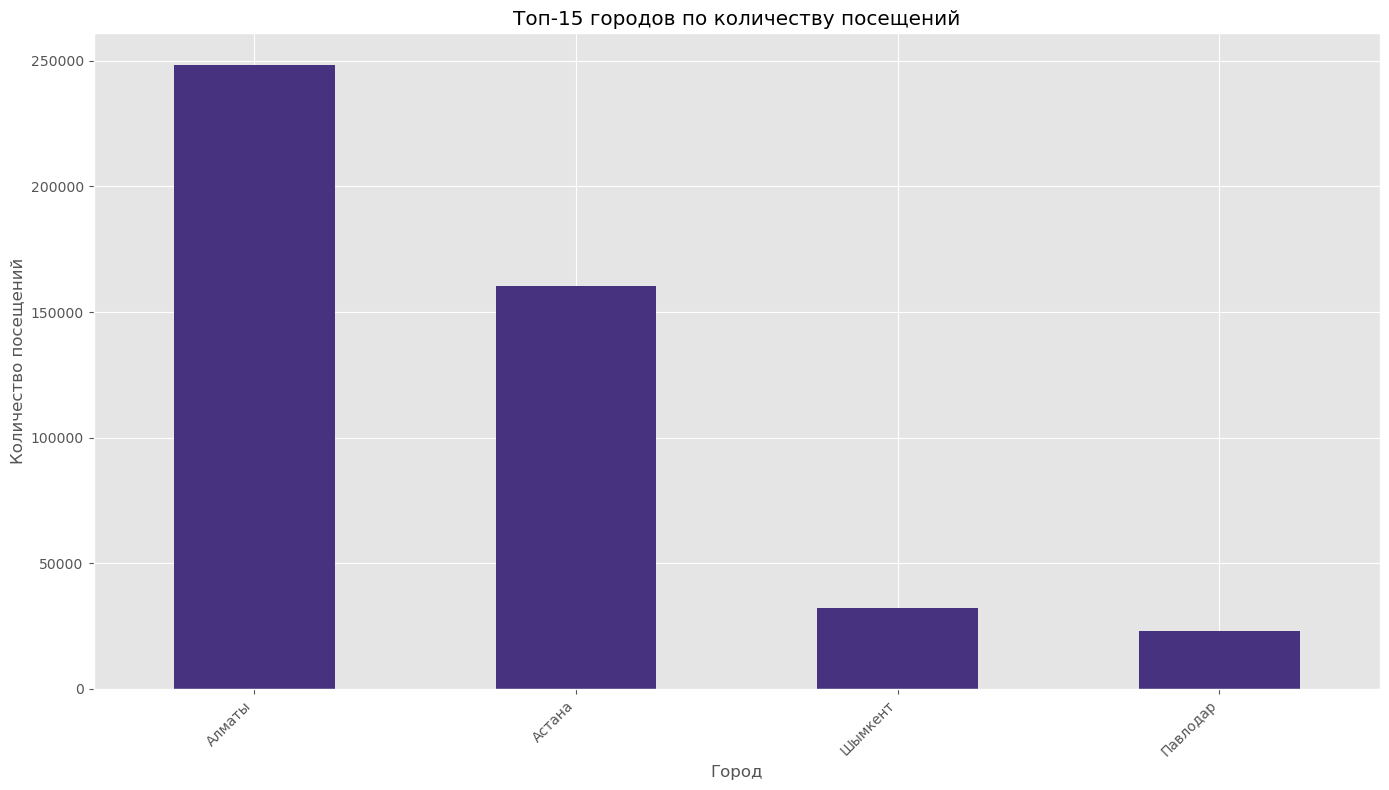

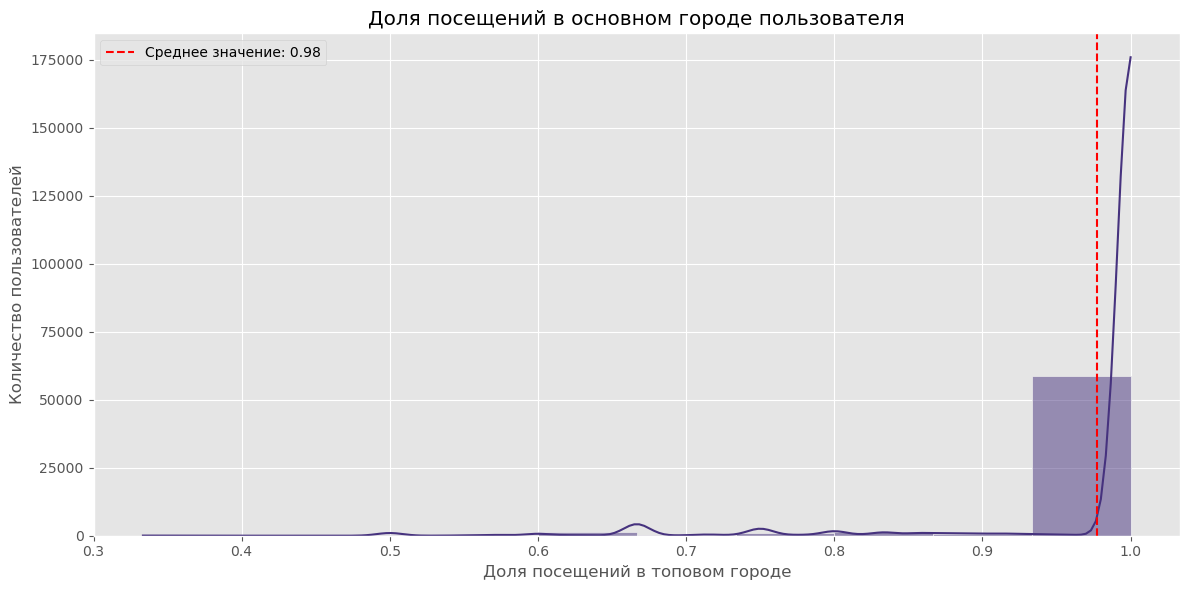

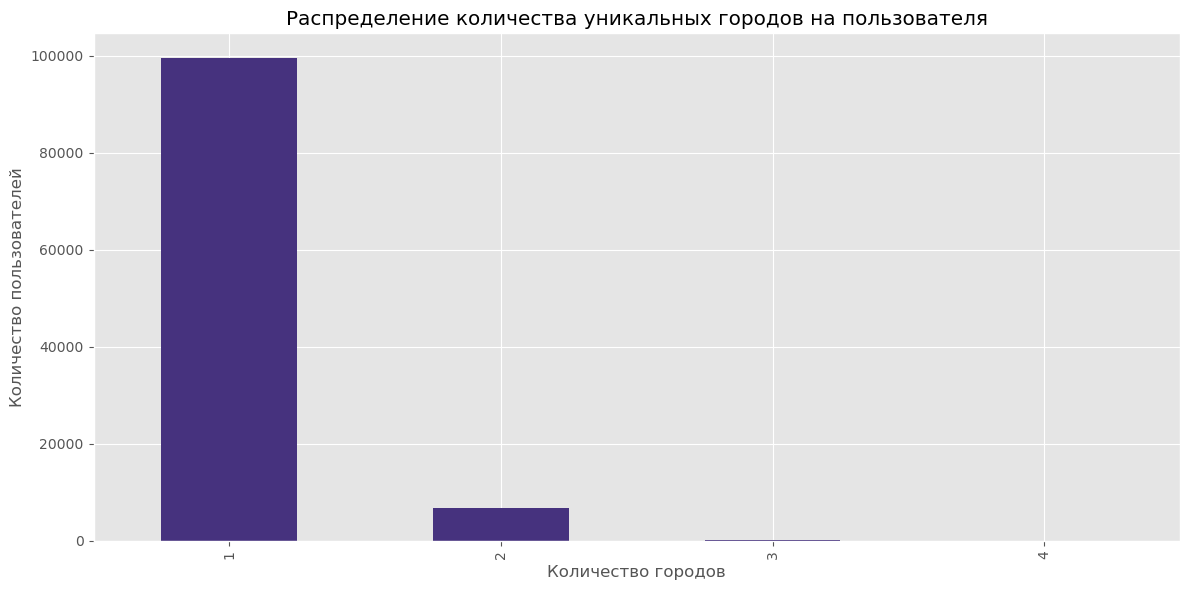

Анализ городской специфики завершен
Cell ended!


In [6]:
print("Анализ городской специфики...")

plt.figure(figsize=(14, 8))
city_counts = paid_interactions['city'].value_counts().head(15)
ax = city_counts.plot(kind='bar')
plt.title('Топ-15 городов по количеству посещений')
plt.xlabel('Город')
plt.ylabel('Количество посещений')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('city_distribution.png')
plt.show()

def top_city_ratio(group):
    if len(group) >= 3:  # Минимум 3 посещения для анализа
        cities = group['city']
        if not cities.empty:
            city_counts = cities.value_counts()
            if not city_counts.empty:
                return city_counts.iloc[0] / len(cities)
    return np.nan

user_city_loyalty = paid_grouped.apply(top_city_ratio).dropna()
loyalty_series = pd.Series(user_city_loyalty)

plt.figure(figsize=(12, 6))
sns.histplot(loyalty_series, bins=10, kde=True)
plt.title('Доля посещений в основном городе пользователя')
plt.xlabel('Доля посещений в топовом городе')
plt.ylabel('Количество пользователей')
plt.axvline(loyalty_series.mean(), color='red', linestyle='--', 
           label=f'Среднее значение: {loyalty_series.mean():.2f}')
plt.legend()
plt.tight_layout()
plt.savefig('city_loyalty.png')
plt.show()

def count_unique_cities(x):
    return len(x.dropna().unique())

user_city_counts = paid_grouped['city'].agg(count_unique_cities)
city_counts_series = pd.Series(user_city_counts)

plt.figure(figsize=(12, 6))
ax = city_counts_series.value_counts().sort_index().plot(kind='bar')
plt.title('Распределение количества уникальных городов на пользователя')
plt.xlabel('Количество городов')
plt.ylabel('Количество пользователей')
plt.tight_layout()
plt.savefig('cities_per_user.png')
plt.show()

print("Анализ городской специфики завершен")
cell_end()

## 7. Гипотеза 5: Холодный старт

Анализируем поведение пользователей с малым количеством исторических данных.

Анализ стратегии холодного старта...
Пользователи с холодным стартом (1-2 истор. посещения): 38515
Новые пользователи (только в марте): 4489
Обычные пользователи (>2 истор. посещений): 32123


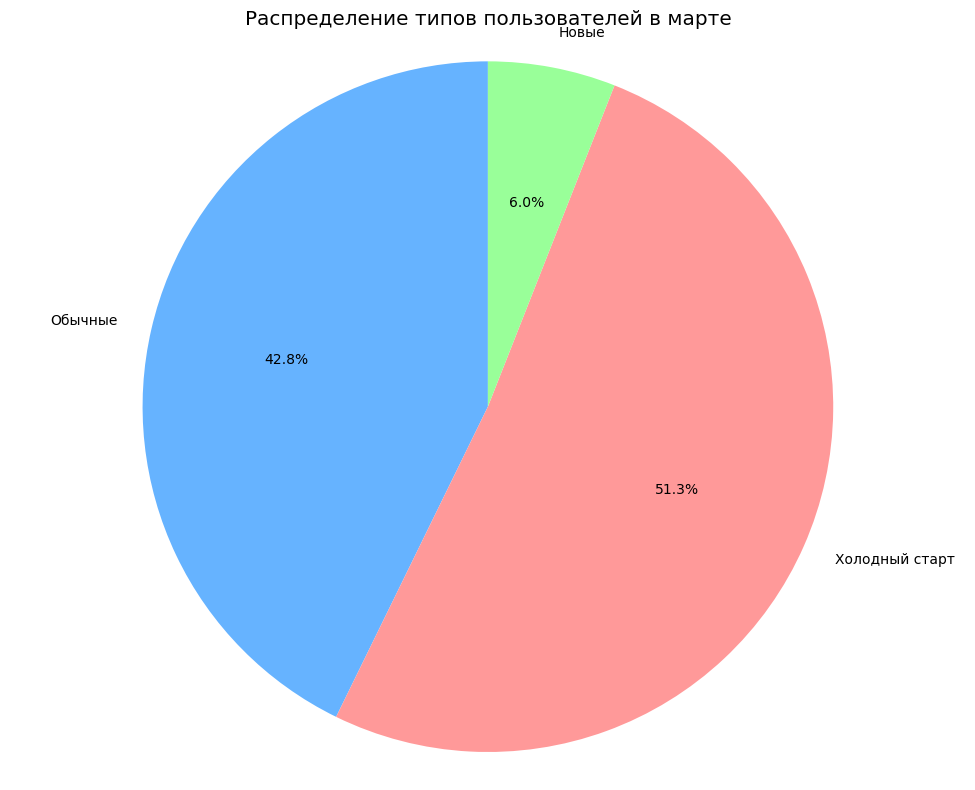

Анализ холодного старта завершен
Cell ended!


In [7]:
print("Анализ стратегии холодного старта...")

users_in_history = set(history_interactions['user_id'].unique())
users_in_march = set(march_interactions['user_id'].unique())

hist_user_counts = history_interactions['user_id'].value_counts()

cold_start_candidates = hist_user_counts[(hist_user_counts >= 1) & (hist_user_counts <= 2)].index
cold_start_users = [user for user in cold_start_candidates if user in users_in_march]

new_users = list(users_in_march - users_in_history)

regular_candidates = hist_user_counts[hist_user_counts > 2].index
regular_users = [user for user in regular_candidates if user in users_in_march]

print(f"Пользователи с холодным стартом (1-2 истор. посещения): {len(cold_start_users)}")
print(f"Новые пользователи (только в марте): {len(new_users)}")
print(f"Обычные пользователи (>2 истор. посещений): {len(regular_users)}")

user_types = [
    len(regular_users),
    len(cold_start_users),
    len(new_users)
]

plt.figure(figsize=(10, 8))
plt.pie(user_types, 
        labels=['Обычные', 'Холодный старт', 'Новые'], 
        autopct='%1.1f%%', 
        colors=['#66b3ff', '#ff9999', '#99ff99'], 
        startangle=90)
plt.title('Распределение типов пользователей в марте')
plt.axis('equal')
plt.tight_layout()
plt.savefig('user_type_distribution.png')
plt.show()

print("Анализ холодного старта завершен")
cell_end()

## 8. Выводы

### Общие выводы по гипотезам

1. **Жанровые и типовые предпочтения**:
   - У большинства пользователей наблюдается устойчивое предпочтение определенных жанров
   - Топовый жанр составляет значительную долю от всех посещений пользователя
   - Наблюдается высокая степень повторяемости предпочтений между историческими данными и мартом
   
2. **Предпочтения по дням недели**:
   - Существует четкое разделение на пользователей с предпочтениями выходных дней и будних дней
   - День недели является устойчивой характеристикой поведения пользователя
   - В марте пользователи во многом сохраняют свои предпочтения по дням недели
   
3. **Частота посещений влияет на рекомендации**:
   - Частые пользователи имеют более разнообразные предпочтения по жанрам
   - Редкие пользователи больше тяготеют к популярным мероприятиям
   - Частые пользователи демонстрируют более высокую лояльность к определенным жанрам
   
4. **Городская специфика**:
   - Большинство пользователей демонстрируют высокую лояльность к одному городу
   - Предпочтения по жанрам различаются между городами
   - В марте пользователи преимущественно сохраняют верность своему основному городу
   
5. **Холодный старт**:
   - Пользователи с холодным стартом и новые пользователи выбирают более популярные мероприятия
   - Пользователи с холодным стартом демонстрируют меньшее разнообразие жанров
   - Стратегия опоры на популярность является эффективной для новых пользователей

### Итоговое заключение

Результаты анализа подтверждают все пять гипотез, лежащих в основе нашей рекомендательной системы. Мы получили подтверждение, что учет жанровых предпочтений, дней недели, частоты посещений, городской специфики и стратегии холодного старта является обоснованным и эффективным подходом к прогнозированию посещений мероприятий в будущем.